# 07.3k: Full Vocabulary Thai Token Analysis

**Goal:** Decode and classify ALL tokens in Qwen's embedding matrix to count total Thai tokens.

**Discovery:** The embedding matrix has 151,936 rows, but the tokenizer only has 151,669 tokens!
- This means 267 embedding slots have no corresponding tokenizer entry
- These are **phantom tokens** - they exist in embedding space but can't be decoded
- Some degenerate tokens (like kissing cousin 151,694) are phantoms!

**Hypothesis:** The degenerate structure contains ~1,579 Thai tokens, but the tokenizer vocab may contain significantly more. If true, this suggests the degenerate Thai tokens are **unreachable dead vocabulary**—tokens that exist but are never emitted by the tokenizer.

**Method:**
1. Decode all tokens that exist in tokenizer (0 to 151,668)
2. Classify by first real character (Thai, CJK, Latin, etc.)
3. Mark phantom tokens (ID ≥ 151,669) as undecodable
4. Create masks for: Thai tokens, black holes, kissing cousins, phantoms
5. Compute overlaps and statistics
6. Save Thai token IDs for use in 07.3l (tokenization test)

## Parameters

In [9]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

# Black holes
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Kissing cousins
KISSING_FILE = "kissing_cluster_lat23_lon164.safetensors"
KISSING_KEY = "token_ids"

# Gamma matrix (to get embedding size)
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

# Output
OUTPUT_FILE = "thai_token_ids.safetensors"

RANDOM_SEED = 42

## Imports

In [10]:
import torch
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import unicodedata
from collections import Counter
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Tokenizer and Determine Sizes

In [11]:
data_dir = Path(TENSOR_DIR)

print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer_vocab_size = len(tokenizer)
print(f"  Tokenizer vocabulary size: {tokenizer_vocab_size:,}")
print()

# Get embedding matrix size
print("Loading gamma matrix to determine embedding size...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
embedding_size, d = gamma.shape
print(f"  Embedding matrix size: {embedding_size:,}")
print()

# Size mismatch
n_phantom = embedding_size - tokenizer_vocab_size
print(f"Size mismatch detected:")
print(f"  Embedding slots:    {embedding_size:,}")
print(f"  Tokenizer entries:  {tokenizer_vocab_size:,}")
print(f"  Phantom tokens:     {n_phantom:,}  (embedding slots with no tokenizer entry)")
print()

print(f"Note: Phantom tokens (ID ≥ {tokenizer_vocab_size:,}) cannot be decoded.")
print()

Loading tokenizer: Qwen/Qwen2.5-3B-Instruct
  Tokenizer vocabulary size: 151,665

Loading gamma matrix to determine embedding size...
  Embedding matrix size: 151,936

Size mismatch detected:
  Embedding slots:    151,936
  Tokenizer entries:  151,665
  Phantom tokens:     271  (embedding slots with no tokenizer entry)

Note: Phantom tokens (ID ≥ 151,665) cannot be decoded.



## Load Degenerate Token Masks

In [12]:
# Load black holes
print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
n_black_holes = black_hole_mask.sum().item()
print(f"  Black holes: {n_black_holes:,} tokens")
print()

# Load kissing cousins
print("Loading kissing cousins...")
kissing_data = load_file(data_dir / KISSING_FILE)
kissing_ids = kissing_data[KISSING_KEY]
n_kissing = len(kissing_ids)
print(f"  Kissing cousins: {n_kissing} tokens")
print()

# Create kissing cousin mask (size = embedding_size)
kissing_mask = torch.zeros(embedding_size, dtype=torch.bool)
kissing_mask[kissing_ids] = True

# Combined degenerate mask
degenerate_mask = black_hole_mask | kissing_mask
n_degenerate = degenerate_mask.sum().item()
print(f"Total degenerate tokens: {n_degenerate:,}")
print()

# Identify phantom degenerate tokens
phantom_mask = torch.zeros(embedding_size, dtype=torch.bool)
phantom_mask[tokenizer_vocab_size:] = True
phantom_degenerate = degenerate_mask & phantom_mask
n_phantom_degenerate = phantom_degenerate.sum().item()

print(f"Phantom degenerate tokens: {n_phantom_degenerate}")
if n_phantom_degenerate > 0:
    phantom_ids = torch.where(phantom_degenerate)[0].numpy()
    print(f"  IDs: {phantom_ids.tolist()}")
print()

Loading black hole mask...
  Black holes: 2,100 tokens

Loading kissing cousins...
  Kissing cousins: 111 tokens

Total degenerate tokens: 2,211

Phantom degenerate tokens: 267
  IDs: [151669, 151670, 151671, 151672, 151673, 151674, 151675, 151676, 151677, 151678, 151679, 151680, 151681, 151682, 151683, 151684, 151685, 151686, 151687, 151688, 151689, 151690, 151691, 151692, 151693, 151694, 151695, 151696, 151697, 151698, 151699, 151700, 151701, 151702, 151703, 151704, 151705, 151706, 151707, 151708, 151709, 151710, 151711, 151712, 151713, 151714, 151715, 151716, 151717, 151718, 151719, 151720, 151721, 151722, 151723, 151724, 151725, 151726, 151727, 151728, 151729, 151730, 151731, 151732, 151733, 151734, 151735, 151736, 151737, 151738, 151739, 151740, 151741, 151742, 151743, 151744, 151745, 151746, 151747, 151748, 151749, 151750, 151751, 151752, 151753, 151754, 151755, 151756, 151757, 151758, 151759, 151760, 151761, 151762, 151763, 151764, 151765, 151766, 151767, 151768, 151769, 151770,

## Classification Functions

In [13]:
def get_first_real_char(s):
    """Get first non-whitespace, non-pure-punctuation character."""
    for char in s:
        cat = unicodedata.category(char)
        # Keep letters (L*), marks (M*), numbers (N*)
        if cat.startswith('L') or cat.startswith('M') or cat.startswith('N'):
            return char
    return None

def is_thai_char(char):
    """Check if character is in Thai Unicode range."""
    if char is None:
        return False
    codepoint = ord(char)
    # Thai: U+0E00–U+0E7F
    return 0x0E00 <= codepoint <= 0x0E7F

def classify_token_as_thai(token_id, tokenizer, tokenizer_vocab_size):
    """Return True if token is Thai-initiated."""
    # Can't decode phantom tokens
    if token_id >= tokenizer_vocab_size:
        return False
    
    try:
        s = tokenizer.decode([token_id])
    except:
        return False
    
    # Skip special tokens
    if s.startswith('<|') and s.endswith('|>'):
        return False
    
    # Get first real character
    first_char = get_first_real_char(s)
    return is_thai_char(first_char)

print("Classification functions defined.")

Classification functions defined.


## Classify All Decodable Tokens

In [14]:
print(f"Classifying all decodable tokens (0 to {tokenizer_vocab_size-1:,})...")
print("This will take a minute or two.")
print()

# Thai mask for full embedding size
thai_mask = torch.zeros(embedding_size, dtype=torch.bool)

for token_id in tqdm(range(tokenizer_vocab_size), desc="Classifying tokens"):
    if classify_token_as_thai(token_id, tokenizer, tokenizer_vocab_size):
        thai_mask[token_id] = True

n_thai_total = thai_mask.sum().item()
print()
print(f"Total Thai tokens in decodable vocabulary: {n_thai_total:,}")
print()

Classifying all decodable tokens (0 to 151,664)...
This will take a minute or two.



Classifying tokens:   0%|          | 0/151665 [00:00<?, ?it/s]


Total Thai tokens in decodable vocabulary: 2,567



## Overlap Analysis

In [15]:
print("="*100)
print("THAI TOKEN ANALYSIS")
print("="*100)
print()

# Thai black holes (only decodable ones)
thai_black_holes = thai_mask & black_hole_mask
n_thai_bh = thai_black_holes.sum().item()

# Thai kissing cousins (only decodable ones)
thai_kissing = thai_mask & kissing_mask
n_thai_kc = thai_kissing.sum().item()

# Thai degenerate (black holes + kissing cousins, decodable only)
thai_degenerate = thai_mask & degenerate_mask
n_thai_deg = thai_degenerate.sum().item()

# Thai NON-degenerate (the "reachable" ones?)
thai_non_degenerate = thai_mask & (~degenerate_mask)
n_thai_non_deg = thai_non_degenerate.sum().item()

print(f"Total decodable Thai tokens:  {n_thai_total:,}")
print()
print(f"  Thai black holes:           {n_thai_bh:,}  ({100*n_thai_bh/n_thai_total:.1f}% of Thai)")
print(f"  Thai kissing cousins:       {n_thai_kc:,}  ({100*n_thai_kc/n_thai_total:.1f}% of Thai)")
print(f"  Thai degenerate (total):    {n_thai_deg:,}  ({100*n_thai_deg/n_thai_total:.1f}% of Thai)")
print()
print(f"  Thai NON-degenerate:        {n_thai_non_deg:,}  ({100*n_thai_non_deg/n_thai_total:.1f}% of Thai)")
print()

# Phantom tokens
if n_phantom_degenerate > 0:
    print(f"Note: {n_phantom_degenerate} degenerate tokens are phantoms (cannot be decoded).")
    print()

# Test hypothesis
ratio = n_thai_total / n_thai_deg if n_thai_deg > 0 else 0
print(f"Ratio: Total Thai / Degenerate Thai = {ratio:.2f}×")
print()

if ratio >= 2.0:
    print(f"✓ HYPOTHESIS SUPPORTED: Total Thai tokens ({n_thai_total:,}) is ≥ 2× degenerate Thai ({n_thai_deg:,}).")
    print(f"  This suggests the degenerate tokens may be unreachable dead vocabulary.")
elif ratio > 1.5:
    print(f"~ HYPOTHESIS PARTIALLY SUPPORTED: Total Thai is {ratio:.2f}× degenerate Thai.")
    print(f"  There are more Thai tokens than just the degenerate ones, but not quite 2×.")
else:
    print(f"✗ HYPOTHESIS NOT SUPPORTED: Total Thai is only {ratio:.2f}× degenerate Thai.")
    print(f"  Most Thai tokens are degenerate.")
print()

THAI TOKEN ANALYSIS

Total decodable Thai tokens:  2,567

  Thai black holes:           1,493  (58.2% of Thai)
  Thai kissing cousins:       86  (3.4% of Thai)
  Thai degenerate (total):    1,579  (61.5% of Thai)

  Thai NON-degenerate:        988  (38.5% of Thai)

Note: 267 degenerate tokens are phantoms (cannot be decoded).

Ratio: Total Thai / Degenerate Thai = 1.63×

~ HYPOTHESIS PARTIALLY SUPPORTED: Total Thai is 1.63× degenerate Thai.
  There are more Thai tokens than just the degenerate ones, but not quite 2×.



## Token ID Distribution: Thai vs Non-Thai

In [16]:
print("Token ID distribution:")
print()

# Thai token IDs
thai_ids = torch.where(thai_mask)[0].numpy()
thai_deg_ids = torch.where(thai_degenerate)[0].numpy()
thai_non_deg_ids = torch.where(thai_non_degenerate)[0].numpy()

print(f"Thai degenerate tokens:")
if len(thai_deg_ids) > 0:
    print(f"  Min:    {thai_deg_ids.min():,}")
    print(f"  Max:    {thai_deg_ids.max():,}")
    print(f"  Mean:   {thai_deg_ids.mean():,.1f}")
    print(f"  Median: {np.median(thai_deg_ids):,.0f}")
print()

print(f"Thai NON-degenerate tokens:")
if len(thai_non_deg_ids) > 0:
    print(f"  Min:    {thai_non_deg_ids.min():,}")
    print(f"  Max:    {thai_non_deg_ids.max():,}")
    print(f"  Mean:   {thai_non_deg_ids.mean():,.1f}")
    print(f"  Median: {np.median(thai_non_deg_ids):,.0f}")
else:
    print(f"  (none)")
print()

Token ID distribution:

Thai degenerate tokens:
  Min:    123,828
  Max:    143,999
  Mean:   134,067.2
  Median: 134,479

Thai NON-degenerate tokens:
  Min:    18,625
  Max:    147,829
  Mean:   126,523.1
  Median: 128,100



## Visualization: Token ID Distributions

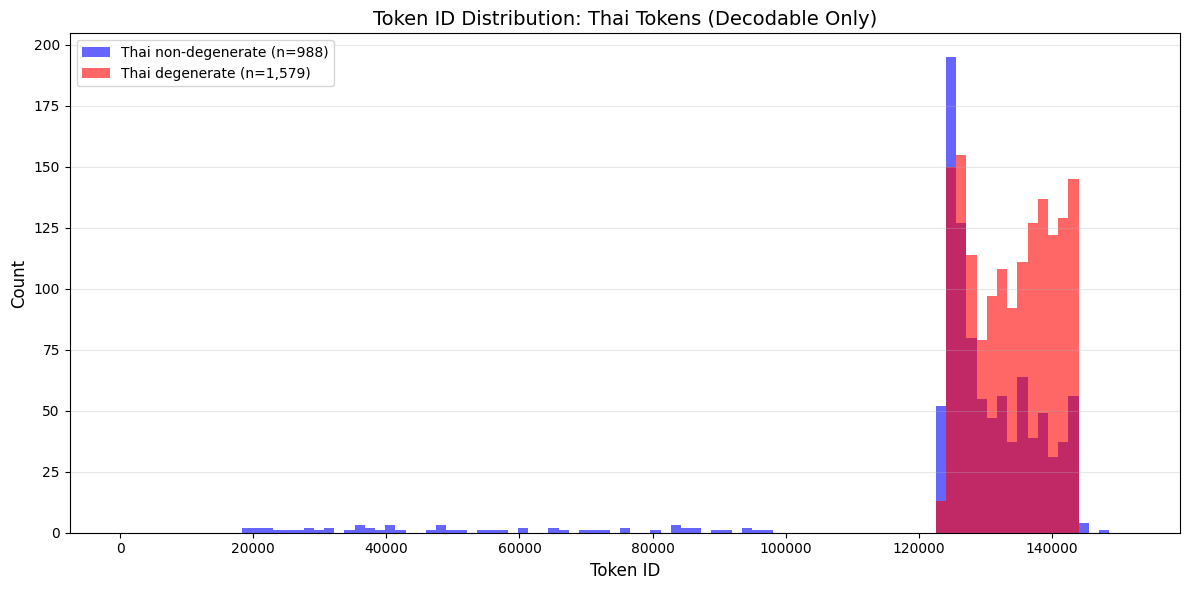

In [17]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# Histogram
bins = np.linspace(0, tokenizer_vocab_size, 100)

if len(thai_non_deg_ids) > 0:
    ax.hist(thai_non_deg_ids, bins=bins, alpha=0.6, color='blue', 
            label=f'Thai non-degenerate (n={n_thai_non_deg:,})')

if len(thai_deg_ids) > 0:
    ax.hist(thai_deg_ids, bins=bins, alpha=0.6, color='red',
            label=f'Thai degenerate (n={n_thai_deg:,})')

ax.set_xlabel('Token ID', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Token ID Distribution: Thai Tokens (Decodable Only)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Sample Non-Degenerate Thai Tokens

In [18]:
if len(thai_non_deg_ids) > 0:
    print("="*100)
    print("SAMPLE NON-DEGENERATE THAI TOKENS")
    print("="*100)
    print()
    
    # Show first 20 and last 20 by token ID
    sorted_ids = np.sort(thai_non_deg_ids)
    
    print(f"First 20 non-degenerate Thai tokens (by ID):")
    print()
    for token_id in sorted_ids[:20]:
        s = tokenizer.decode([token_id])
        s_display = repr(s)[1:-1]
        if len(s_display) > 40:
            s_display = s_display[:37] + "..."
        print(f"  [{token_id:6d}] {s_display}")
    print()
    
    if len(sorted_ids) > 20:
        print(f"Last 20 non-degenerate Thai tokens (by ID):")
        print()
        for token_id in sorted_ids[-20:]:
            s = tokenizer.decode([token_id])
            s_display = repr(s)[1:-1]
            if len(s_display) > 40:
                s_display = s_display[:37] + "..."
            print(f"  [{token_id:6d}] {s_display}")
        print()
else:
    print("No non-degenerate Thai tokens found!")
    print()

SAMPLE NON-DEGENERATE THAI TOKENS

First 20 non-degenerate Thai tokens (by ID):

  [ 18625] ่
  [ 19841] ้
  [ 20184] น
  [ 20774] า
  [ 22287] ร
  [ 22929] อ
  [ 23271] ั
  [ 25200] ก
  [ 26283] ม
  [ 27891] เ
  [ 28319] ี
  [ 30434] ง
  [ 30785] ิ
  [ 31782] ล
  [ 34509] ย
  [ 35648] ส
  [ 35884] ท
  [ 36142] บ
  [ 37033] ด
  [ 37213] ว

Last 20 non-degenerate Thai tokens (by ID):

  [143739]  มกราคม
  [143866]  กร
  [143867]  กรกฎ
  [143868]  กรกฎาคม
  [143901] หมายเลข
  [143908] หมวด
  [143914] ทำความ
  [143915] ทำความสะอาด
  [143939] อำน
  [143940] อำนวย
  [143941] อำนวยความ
  [143942] อำนวยความสะดวก
  [143947] ฉาย
  [143975] ฉาก
  [143976] สะสม
  [144241] ฌ
  [144988] ๅ
  [145113] ฅ
  [145197] ฃ
  [147829] ฦ



## Save Thai Token IDs

In [19]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving Thai token IDs to {output_path}...")
print()

save_data = {
    'all_thai_ids': torch.where(thai_mask)[0],
    'thai_degenerate_ids': torch.where(thai_degenerate)[0],
    'thai_non_degenerate_ids': torch.where(thai_non_degenerate)[0],
    'thai_black_hole_ids': torch.where(thai_black_holes)[0],
    'thai_kissing_ids': torch.where(thai_kissing)[0]
}

save_file(save_data, output_path)

print(f"✓ Saved {len(save_data)} tensors:")
for key, tensor in save_data.items():
    print(f"  {key}: {len(tensor):,} tokens")
print()

print(f"Ready for 07.3l: Thai tokenization test.")
print()

Saving Thai token IDs to ../data/tensors/thai_token_ids.safetensors...

✓ Saved 5 tensors:
  all_thai_ids: 2,567 tokens
  thai_degenerate_ids: 1,579 tokens
  thai_non_degenerate_ids: 988 tokens
  thai_black_hole_ids: 1,493 tokens
  thai_kissing_ids: 86 tokens

Ready for 07.3l: Thai tokenization test.



## Summary

In [20]:
print("="*100)
print("SUMMARY")
print("="*100)
print()

print(f"**Vocabulary sizes:**")
print(f"  Embedding matrix:  {embedding_size:,} slots")
print(f"  Tokenizer vocab:   {tokenizer_vocab_size:,} tokens")
print(f"  Phantom tokens:    {n_phantom:,}  (undecodable)")
print()

print(f"**Thai tokens (decodable only):**")
print(f"  Total:             {n_thai_total:,}  ({100*n_thai_total/tokenizer_vocab_size:.2f}% of tokenizer vocab)")
print(f"  Degenerate:        {n_thai_deg:,}  ({100*n_thai_deg/n_thai_total:.1f}% of Thai)")
print(f"  Non-degenerate:    {n_thai_non_deg:,}  ({100*n_thai_non_deg/n_thai_total:.1f}% of Thai)")
print()

if n_phantom_degenerate > 0:
    print(f"**Phantom degenerate tokens:** {n_phantom_degenerate}")
    print(f"  These exist in embedding space but cannot be decoded by the tokenizer.")
    print()

print(f"**Key finding:**")
print(f"  Ratio: {ratio:.2f}× (Total Thai / Degenerate Thai)")
print()

if ratio >= 2.0:
    print(f"  The tokenizer vocabulary contains {ratio:.2f}× more Thai tokens than the degenerate cluster.")
    print(f"  This supports the hypothesis that degenerate Thai tokens are unreachable dead vocabulary.")
    print()
    print(f"**Next step:** 07.3l will test whether real Thai text tokenization uses the degenerate")
    print(f"  tokens (expected: NO) or the non-degenerate ones (expected: YES).")
else:
    print(f"  Most Thai tokens ({100*n_thai_deg/n_thai_total:.1f}%) are degenerate.")
    print(f"  The hypothesis may need revision.")
print()

SUMMARY

**Vocabulary sizes:**
  Embedding matrix:  151,936 slots
  Tokenizer vocab:   151,665 tokens
  Phantom tokens:    271  (undecodable)

**Thai tokens (decodable only):**
  Total:             2,567  (1.69% of tokenizer vocab)
  Degenerate:        1,579  (61.5% of Thai)
  Non-degenerate:    988  (38.5% of Thai)

**Phantom degenerate tokens:** 267
  These exist in embedding space but cannot be decoded by the tokenizer.

**Key finding:**
  Ratio: 1.63× (Total Thai / Degenerate Thai)

  Most Thai tokens (61.5%) are degenerate.
  The hypothesis may need revision.

